In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils')
from GridWorld import get_negative_grid, get_standard_grid
from iterative_policy_eval import printValues, printPolicy

GAMMA = 0.9
ACTIONS = ('U', 'D', 'L', 'R')

In [2]:
def epsilon_greedy(policy, s, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return policy[s]
    else:
        return np.random.choice(ACTIONS)

def playGame(grid, policy, max_steps=20):
    s = grid.reset()
    a = epsilon_greedy(policy, s)

    states = [s]
    actions = [a]
    rewards = [0]

    for _ in range(max_steps):
        r = grid.move(a)
        s = grid.current_state()

        rewards.append(r)
        states.append(s)

        if grid.game_over():
            break
        else:
            a = epsilon_greedy(policy, s)
            actions.append(a)

    return states, actions, rewards

def max_dict(d):
    # returns the argmax key and max value from a dictionary
    max_val = max(d.values())
    max_keys = [key for key, val in d.items() if val == max_val]

    return np.random.choice(max_keys), max_val

rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


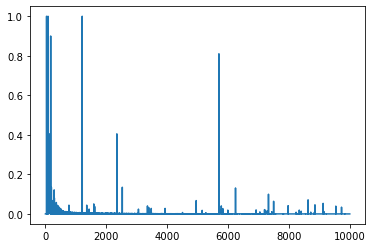

final policy:
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | L | U | D |
final values:
-------------------------
 0.79| 0.89| 1.00| 0.00|
-------------------------
 0.70| 0.00| 0.89| 0.00|
-------------------------
 0.62| 0.54| 0.79| 0.00|
state_sample_count:
         0        1        2    3
0  10738.0  10724.0  10691.0  0.0
1  10806.0      0.0    255.0  0.0
2  10805.0    314.0     24.0  6.0


In [3]:
grid = get_standard_grid()

print("rewards:")
printValues(grid.rewards, grid)

policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ACTIONS)

Q = {}
state_sample_count = {}
sample_counts = {}
states = grid.all_states()

for s in states:
    if s in grid.actions:
        Q[s] = {}
        sample_counts[s] = {}
        state_sample_count[s] = 0

        for a in ACTIONS:
            Q[s][a] = 0
            sample_counts[s][a] = 0
    else:
        pass

# repeat until convergence
deltas = []
for it in range(10000):
    if it % 1000 == 0:
        print(it)

    biggest_change = 0
    states, actions, rewards = playGame(grid, policy)

    states_actions = list(zip(states, actions))

    T = len(states)
    G = 0

    for t in range(T-2, -1, -1):
        s = states[t]
        a = actions[t]

        G = rewards[t+1] + GAMMA * G

        if (s, a) not in states_actions[:t]:
            old_q = Q[s][a]
            sample_counts[s][a] += 1
            lr = 1 / sample_counts[s][a] # learning rate
            Q[s][a] = old_q + lr * (G - old_q)

            policy[s] = max_dict(Q[s])[0]

            state_sample_count[s] += 1

            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
    deltas.append(biggest_change)

plt.plot(deltas)
plt.show()

print("final policy:")
printPolicy(policy, grid)

V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

print("final values:")
printValues(V, grid)

print("state_sample_count:")
state_sample_count_arr = np.zeros((grid.rows, grid.cols))
for i in range(grid.rows):
    for j in range(grid.cols):
        if (i, j) in state_sample_count:
            state_sample_count_arr[i, j] = state_sample_count[(i, j)]

df = pd.DataFrame(state_sample_count_arr)
print(df)